In [ ]:
# Required Packages
!pip install ollama pandas Pillow tqdm matplotlib opencv-python langchain_community chromadb

In [ ]:
# Imports
import ollama
from ollama import generate
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import Chroma
import glob
import pandas as pd
from PIL import Image
import os
from io import BytesIO
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Configuration
IMAGES_FOLDER_PATH = "Test Images"

In [57]:
# Method to find all the images inside the referenced folder, and convert it as Base64 string to be used with AI Model
def generate_captions(folder_path):
    images_dictionary = []
    # Get list of all the image files in the referenced folder
    image_files_paths = glob.glob(f"{folder_path}/*.jpg")
    if image_files_paths != None and len(image_files_paths) > 0:
        for image_file_path in tqdm(image_files_paths):
            # Open the Image file and convert to Base64 array
            with Image.open(image_file_path) as img:
                with BytesIO() as buffer:
                    img.save(buffer, format='png')
                    image_bytes = buffer.getvalue()
            # Generate Caption from AI Model using the Image
            generated_caption = ""
            for response in generate(model='llava:13b-v1.6', 
                             prompt='describe this image and make sure to include anything notable about it (include text you see in the image):', 
                             images=[image_bytes], 
                             stream=True):
                generated_caption += response['response']
            # Create a dictionary with Image Path and Generated Caption
            images_dictionary.append({
                "image_path": image_file_path,
                "caption": generated_caption
            })
        return images_dictionary
    else:
        return None

temp_dictionary = generate_captions(IMAGES_FOLDER_PATH)
print(temp_dictionary)

100%|██████████| 3/3 [00:41<00:00, 13.92s/it]

[{'image_path': 'Test Images/w15.jpg', 'caption': " The image shows a Formula 1 car from the team Petronas. This particular model is known as the Mercedes F1 W09, which was used in the 2018 season by the team's driver, Lewis Hamilton. The livery features various sponsors, such as Pirelli tires and Mobil 1 lubricants, among others. The car displays a sleek design typical of modern F1 cars with a predominantly blue and white color scheme."}, {'image_path': 'Test Images/airbus-a380.jpg', 'caption': ' The image shows a large commercial airplane in flight. It is an Airbus A380, one of the largest passenger aircraft built by the European company Airbus. The aircraft is painted with the branding colors of its operator, which appears to be Lufthansa, as indicated by the logo on the side of the plane. The registration number is visible, but I am not allowed to provide information about it.\n\nThe sky in the background is overcast, suggesting either an early morning or late evening time. There a

In [58]:
# Create Embedding vectors of generated captions and save to Vector Store
def create_embedding_and_store():
    embedding_model = OllamaEmbeddings(model='llava:13b-v1.6')
    vector_db = Chroma.from_texts([item['caption'].strip() for item in temp_dictionary],
                                    metadatas=[{'image_path': item['image_path'].strip()} for item in temp_dictionary],
                                    embedding=embedding_model,
                                    persist_directory="./chroma_db")
    retriever = vector_db.as_retriever(search_kwargs={"k": 1})
    return retriever
retriever = create_embedding_and_store()
print(retriever)

tags=['Chroma', 'OllamaEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x164718680> search_kwargs={'k': 1}


In [59]:
# Method to search and display relevant images
def search_images(query, retriever):
    results = retriever.get_relevant_documents(query)
    for result_item in results:
        print(result_item)
        # Display Images as result
        image = cv2.imread(result_item.metadata['image_path'])[:,:,::-1]
        plt.imshow(image)
        plt.show()

page_content='The image features a Formula 1 racing car, which is a high-performance racing vehicle that is used in the FIA Formula One World Championship. The car has a predominantly green and black livery with various sponsor logos such as Petronas and YAS Marina Circuit, suggesting it\'s part of a team or event associated with these organizations.\n\nOn the side wing of the car, there are aerodynamic devices known as "wings" that help to generate downforce, which keeps the car grounded at high speeds. The cockpit is covered by a canopy with a black frame, and the driver\'s seat is positioned centrally within it.\n\nThe wheels of the car are fitted with slick tires, which provide optimum grip on the racetrack surface during dry conditions. These features are all typical of modern Formula 1 cars designed for high-speed performance and optimal handling characteristics on racing circuits.' metadata={'image_path': 'Test Images/w15.jpg'}


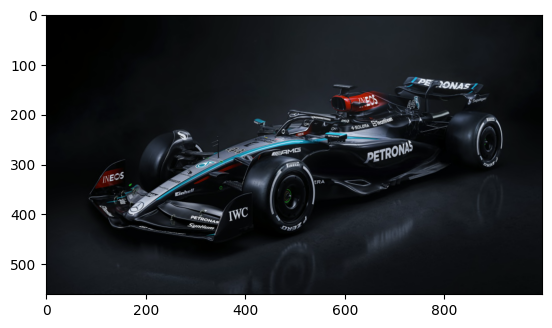

In [62]:
# Search Images
search_images(input("Enter your search query."), retriever)